<a href="https://colab.research.google.com/github/NMashalov/Generative-modeling-appliance-for-creating-educational-tasks/blob/master/tutorial/YOLO_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset

Exported labeled dataset from LabelStudio in COCO format

In [1]:
!gdown 1voOR6G4uIiS-q02ABAls4U-IvnzkHecF

Downloading...
From (original): https://drive.google.com/uc?id=1voOR6G4uIiS-q02ABAls4U-IvnzkHecF
From (redirected): https://drive.google.com/uc?id=1voOR6G4uIiS-q02ABAls4U-IvnzkHecF&confirm=t&uuid=7b3a418e-b3a0-451f-bdd6-6f63ffd6545b
To: /content/ocr_dataset.zip
100% 72.6M/72.6M [00:00<00:00, 130MB/s]


In [2]:
!unzip ocr_dataset.zip > /dev/null

In [3]:
import json
# edit path to images in result.json to /content/images/
with open('./result.json','r') as f:
    j = json.loads(f.read())

from pathlib import Path
for img in j['images']:
    img['file_name'] = str(Path('/content/images')/ Path(img['file_name']).name)

with open('./result_colab.json','w') as f:
    f.write(json.dumps(j))

## Extract cropped images from COCO format

In [ ]:
from pycocotools.coco import COCO
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
!pip install pycocotools

In [ ]:
coco = COCO('result_colab.json')
cat_ids = coco.getCatIds()

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [ ]:
def process_img(img: list[np.array]):
    anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
    anns = coco.loadAnns(anns_ids)
    image = np.array(Image.open(img['file_name']).convert('L'))
    cropped_images = []

    for ann in anns:
        x,y,w,h = map(int,ann['bbox'])
        if ann['category_id'] == 0: # only pictures
            cropped_images.append(image[y:y+h,x:x+w])
    return cropped_images

In [ ]:
from tqdm import tqdm
cropped_image = []
for img in tqdm(coco.imgs.values()):
    cropped_image.extend(process_img(img))

100%|██████████| 201/201 [00:36<00:00,  5.46it/s]


In [ ]:
!mkdir illustrations/

In [ ]:
# save all image
for i,crop_img in tqdm(enumerate(cropped_image)):
    try:
        Image.fromarray(crop_img).save(f'illustrations/{i}.png')
    except:
        continue

183it [00:01, 107.10it/s]


In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00


In [ ]:
!cd illustrations && mkdir physics && mv *.png physics/

In [ ]:
from google.colab import userdata
token = userdata.get('HuggingFaceToken')

In [ ]:
from datasets import load_dataset

dataset = load_dataset("illustrations", data_dir="physics", split="train")
dataset.push_to_hub("NMashalov/task_illustrations_dataset",token=token )

Resolving data files:   0%|          | 0/182 [00:00<?, ?it/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/182 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/NMashalov/task_illustrations_dataset/commit/814683fa149eb390f1d559d438ca1d8c5c085ec6', commit_message='Upload dataset', commit_description='', oid='814683fa149eb390f1d559d438ca1d8c5c085ec6', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
import sys
sys.getsizeof(cropped_image)

3256

## YOLO tunning

In [ ]:
!git clone https://github.com/akarazniewicz/cocosplit

Cloning into 'cocosplit'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 39 (delta 10), reused 29 (delta 4), pack-reused 0
Receiving objects: 100% (39/39), 8.43 KiB | 8.43 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [ ]:
!cat cocosplit/requirements.txt | xargs -n 1 pip install

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 3.3 MB/s eta 0:00:00


In [ ]:
!python cocosplit/cocosplit.py --having-annotations --multi-class -s 0.8 /content/result_colab.json train.json test.json

Saved 778 entries in train.json and 195 in test.json


In [ ]:
!pip install pytorch-lightning > /dev/null

In [ ]:
import torchvision
import os
from tqdm import tqdm
import albumentations as A

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, train=True):
        ann_file = "train.json" if train else "test.json"
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

        self.transform = A.Compose([
                A.RandomCrop(width=450, height=450),
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.2),
            ], bbox_params=A.BboxParams(format='coco',label_fields=['class_labels']))

        self.dataset = []
        for idx in tqdm(range(len(self))):
            img, target = super(CocoDetection, self).__getitem__(idx)

            bbox = [targ['bbox'] for targ in target]
            label = [targ['category_id'] for targ in target]
            try:
                transformed = self.transform(image=np.array(img), bboxes=bbox,class_labels = label, min_area=1024, min_visibility=0.1,)
            except:
                display(img)

            img = transformed['image']

            targ = [
                {
                    'bbox': box,
                    'category_id': label
                }
                for box, label in zip(transformed['bboxes'],transformed['class_labels'])
            ]

            image_id = self.ids[idx]

            target = {'image_id': image_id, 'annotations': target}

            encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")


            self.dataset.append((encoding["pixel_values"].squeeze(),encoding["labels"][0] ))


    def __getitem__(self, idx):
        return self.dataset[idx]


In [ ]:
from transformers import AutoFeatureExtractor
feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-small", size=512, max_size=864)

/usr/local/lib/python3.10/dist-packages/transformers/models/yolos/feature_extraction_yolos.py:38: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!




  0%|          | 0/151 [00:00<?, ?it/s]

  1%|          | 1/151 [00:00<00:20,  7.24it/s]

  1%|▏         | 2/151 [00:00<00:21,  6.92it/s]

  2%|▏         | 3/151 [00:00<00:21,  6.80it/s]

  3%|▎         | 4/151 [00:00<00:21,  6.81it/s]

  3%|▎         | 5/151 [00:00<00:21,  6.81it/s]

  4%|▍         | 6/151 [00:00<00:22,  6.59it/s]

  5%|▍         | 7/151 [00:01<00:22,  6.46it/s]

  5%|▌         | 8/151 [00:01<00:21,  6.56it/s]

  6%|▌         | 9/151 [00:01<00:21,  6.59it/s]

  7%|▋         | 10/151 [00:01<00:21,  6.65it/s]

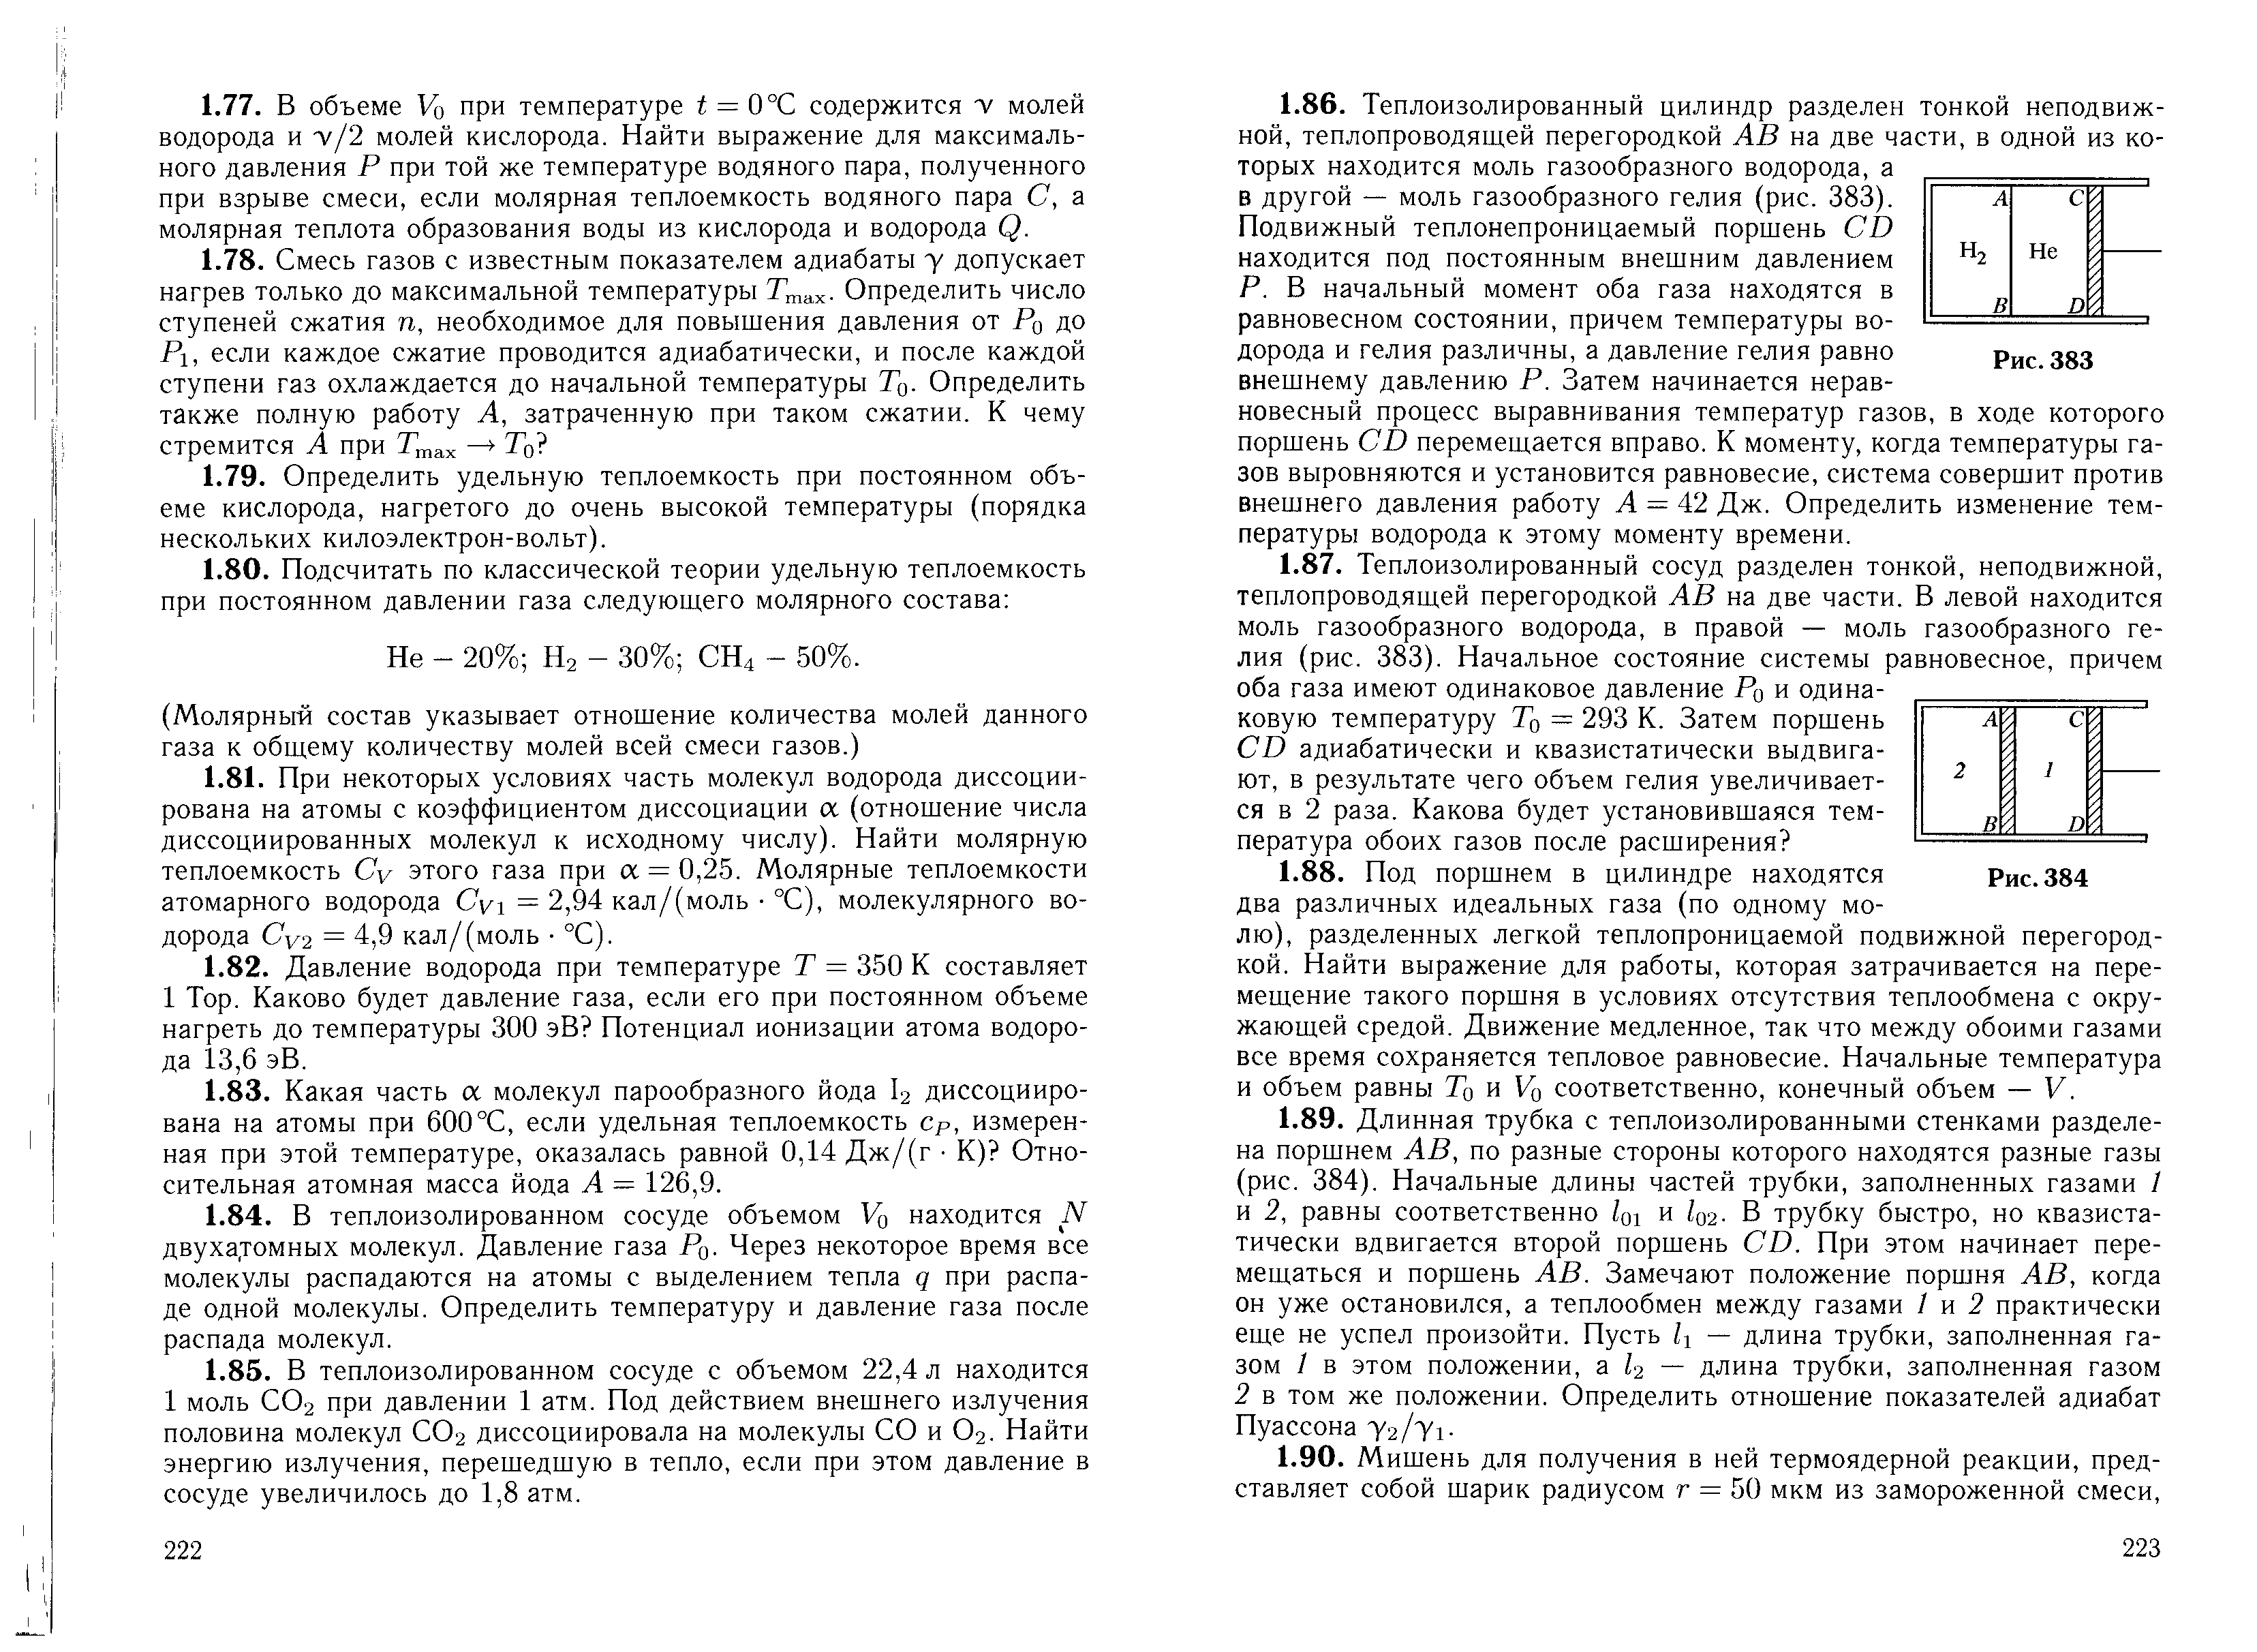



  7%|▋         | 11/151 [00:02<00:39,  3.57it/s]

  8%|▊         | 12/151 [00:02<00:35,  3.92it/s]

  9%|▊         | 13/151 [00:02<00:31,  4.36it/s]

  9%|▉         | 14/151 [00:02<00:27,  4.89it/s]

 10%|▉         | 15/151 [00:02<00:26,  5.17it/s]

 11%|█         | 16/151 [00:02<00:24,  5.44it/s]

 11%|█▏        | 17/151 [00:03<00:23,  5.66it/s]

 12%|█▏        | 18/151 [00:03<00:23,  5.71it/s]

 13%|█▎        | 19/151 [00:03<00:23,  5.65it/s]

 13%|█▎        | 20/151 [00:03<00:23,  5.46it/s]

 14%|█▍        | 21/151 [00:03<00:26,  5.00it/s]

 15%|█▍        | 22/151 [00:04<00:27,  4.68it/s]

 15%|█▌        | 23/151 [00:04<00:29,  4.37it/s]

 16%|█▌        | 24/151 [00:04<00:29,  4.34it/s]

 17%|█▋        | 25/151 [00:04<00:29,  4.22it/s]

 17%|█▋        | 26/151 [00:05<00:30,  4.10it/s]

 18%|█▊        | 27/151 [00:05<00:30,  4.03it/s]

 19%|█▊        | 28/151 [00:05<00:30,  3.97it/s]

 19%|█▉        | 29/151 [00:05<00:29,  4.10it/s]

 20%|█▉        | 30/151 [00:06<00:29,  4.17it/s]

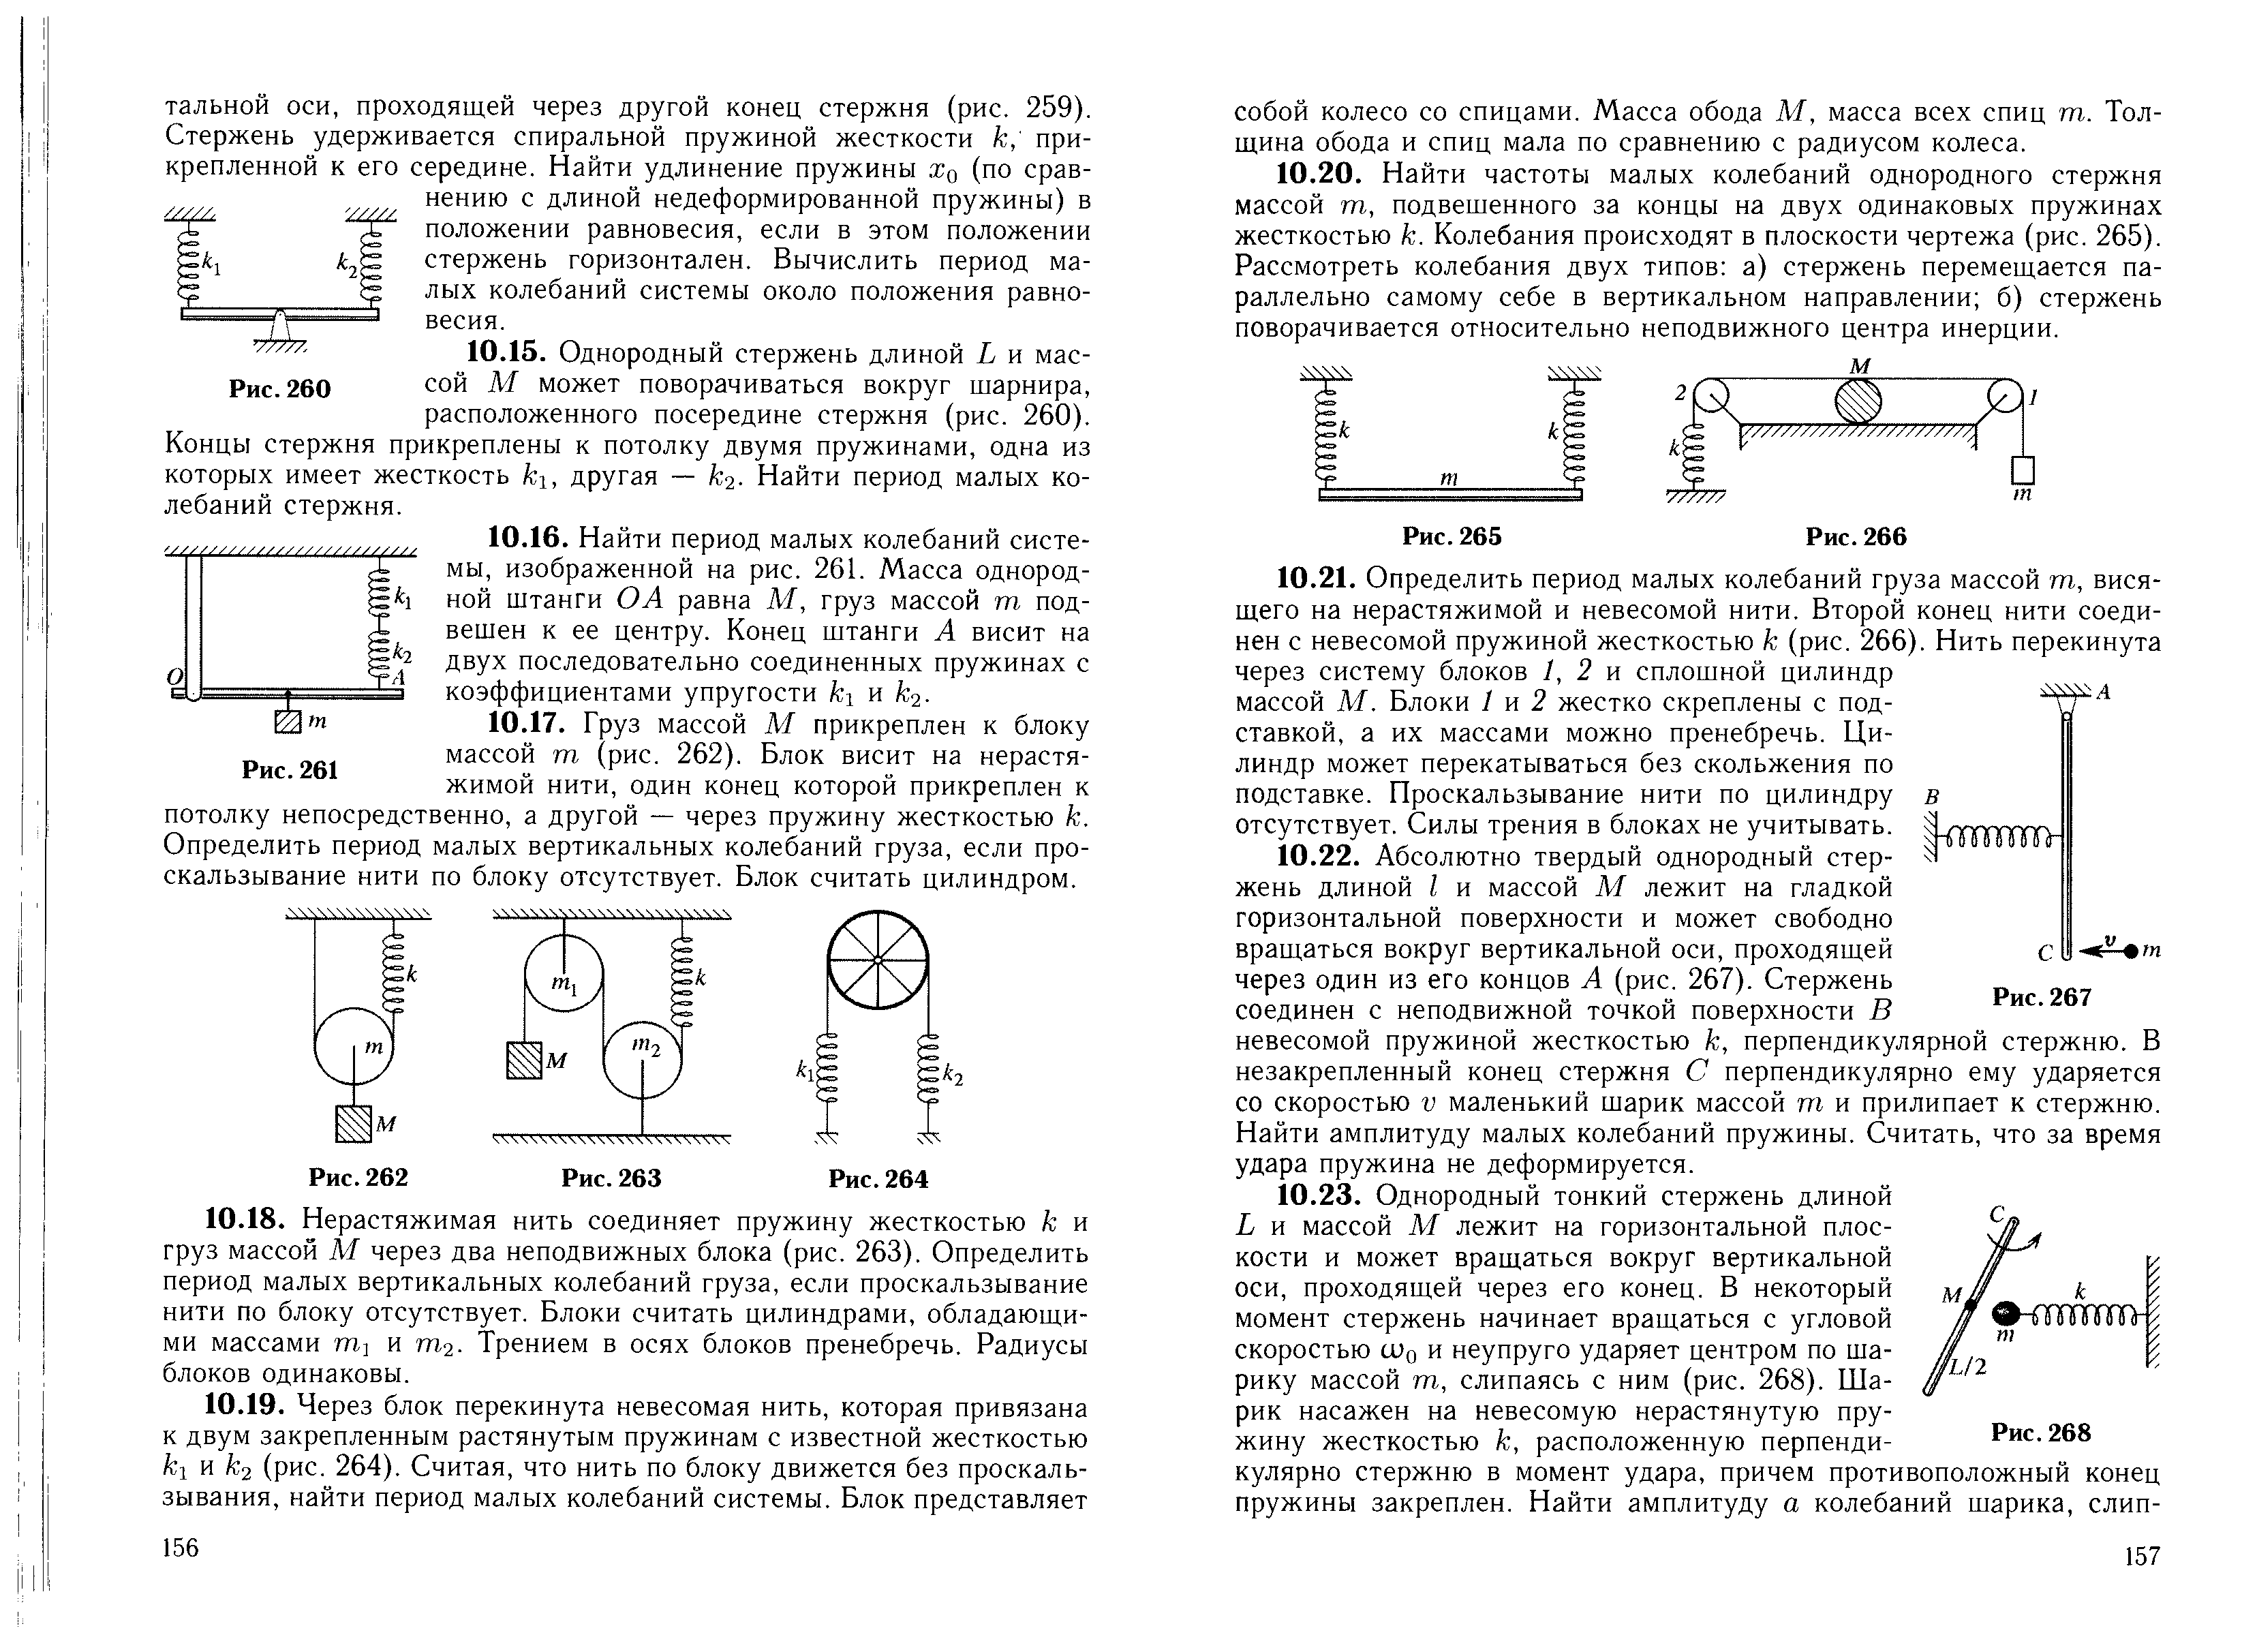



 87%|████████▋ | 131/151 [00:23<00:05,  3.62it/s]

 87%|████████▋ | 132/151 [00:23<00:04,  4.02it/s]

 88%|████████▊ | 133/151 [00:24<00:04,  4.40it/s]

 89%|████████▊ | 134/151 [00:24<00:03,  4.82it/s]

 89%|████████▉ | 135/151 [00:24<00:03,  5.06it/s]

 90%|█████████ | 136/151 [00:24<00:02,  5.30it/s]

 91%|█████████ | 137/151 [00:24<00:02,  5.49it/s]

 91%|█████████▏| 138/151 [00:24<00:02,  5.63it/s]

 92%|█████████▏| 139/151 [00:25<00:02,  5.72it/s]

 93%|█████████▎| 140/151 [00:25<00:01,  5.90it/s]

 93%|█████████▎| 141/151 [00:25<00:01,  5.95it/s]

 94%|█████████▍| 142/151 [00:25<00:01,  5.97it/s]

 95%|█████████▍| 143/151 [00:25<00:01,  6.01it/s]

 95%|█████████▌| 144/151 [00:25<00:01,  5.90it/s]

 96%|█████████▌| 145/151 [00:26<00:01,  5.89it/s]

 97%|█████████▋| 146/151 [00:26<00:00,  5.99it/s]

 97%|█████████▋| 147/151 [00:26<00:00,  6.11it/s]

 98%|█████████▊| 148/151 [00:26<00:00,  6.17it/s]

 99%|█████████▊| 149/151 [00:26<00:00,  6.08it/s]

 99%|█████████▉| 150/151 [00:

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!




  0%|          | 0/101 [00:00<?, ?it/s]

  1%|          | 1/101 [00:00<00:18,  5.50it/s]

  2%|▏         | 2/101 [00:00<00:17,  5.79it/s]

  3%|▎         | 3/101 [00:00<00:16,  5.99it/s]

  4%|▍         | 4/101 [00:00<00:16,  6.01it/s]

  5%|▍         | 5/101 [00:00<00:16,  5.95it/s]

  6%|▌         | 6/101 [00:01<00:16,  5.82it/s]

  7%|▋         | 7/101 [00:01<00:15,  5.91it/s]

  8%|▊         | 8/101 [00:01<00:15,  5.98it/s]

  9%|▉         | 9/101 [00:01<00:15,  6.00it/s]

 10%|▉         | 10/101 [00:01<00:15,  5.98it/s]

 11%|█         | 11/101 [00:01<00:15,  5.88it/s]

 12%|█▏        | 12/101 [00:02<00:16,  5.48it/s]

 13%|█▎        | 13/101 [00:02<00:18,  4.89it/s]

 14%|█▍        | 14/101 [00:02<00:18,  4.75it/s]

 15%|█▍        | 15/101 [00:02<00:18,  4.64it/s]

 16%|█▌        | 16/101 [00:03<00:19,  4.45it/s]

 17%|█▋        | 17/101 [00:03<00:19,  4.21it/s]

 18%|█▊        | 18/101 [00:03<00:20,  4.14it/s]

 19%|█▉        | 19/101 [00:03<00:19,  4.15it/s]

 20%|█▉        |

In [ ]:
train_dataset = CocoDetection(img_folder='/content/images', feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder='/content/images', feature_extractor=feature_extractor, train=False)

In [ ]:
train_dataset[50]

(tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],
 
         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],
 
         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ...,

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=4)
batch = next(iter(train_dataloader))

In [ ]:
import pytorch_lightning as pl
from transformers import DetrConfig, AutoModelForObjectDetection
import torch

class Detr(pl.LightningModule):

     def __init__(self, lr, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         self.model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-small",
                                                             num_labels=2,
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.weight_decay = weight_decay

     def forward(self, pixel_values):
       outputs = self.model(pixel_values=pixel_values)

       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [ ]:
model = Detr(lr=2.5e-5, weight_decay=1e-4)

#outputs = model(pixel_values=batch['pixel_values'])

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-small and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 384]) in the checkpoint and torch.Size([3, 384]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

8556

In [ ]:
from pytorch_lightning import Trainer

trainer = Trainer( max_steps=2000, gradient_clip_val=0.1, accumulate_grad_batches=4)
trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                    | Params
--------------------------------------------------
0 | model | YolosForObjectDetection | 30.7 M
--------------------------------------------------
30.7 M    Trainable params
0         Non-trainable params
30.7 M    Total params
122.602   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (38) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


### Check

In [ ]:
import torch
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        # text = f'Text'
        # ax.text(xmin, ymin, text, fontsize=15,
        #         bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
def visualize_predictions(image, outputs, threshold=0.9):
  # keep only predictions with confidence >= threshold
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold

  # convert predicted boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

  # plot results
  plot_results(image, probas[keep], bboxes_scaled)

In [ ]:
#We can use the image_id in target to know which image it is
pixel_values, target = val_dataset[10]

In [ ]:
pixel_values = pixel_values.unsqueeze(0).to('cuda')
print(pixel_values.shape)

torch.Size([1, 3, 512, 699])


In [ ]:
# forward pass to get class logits and bounding boxes
outputs = model(pixel_values=pixel_values)

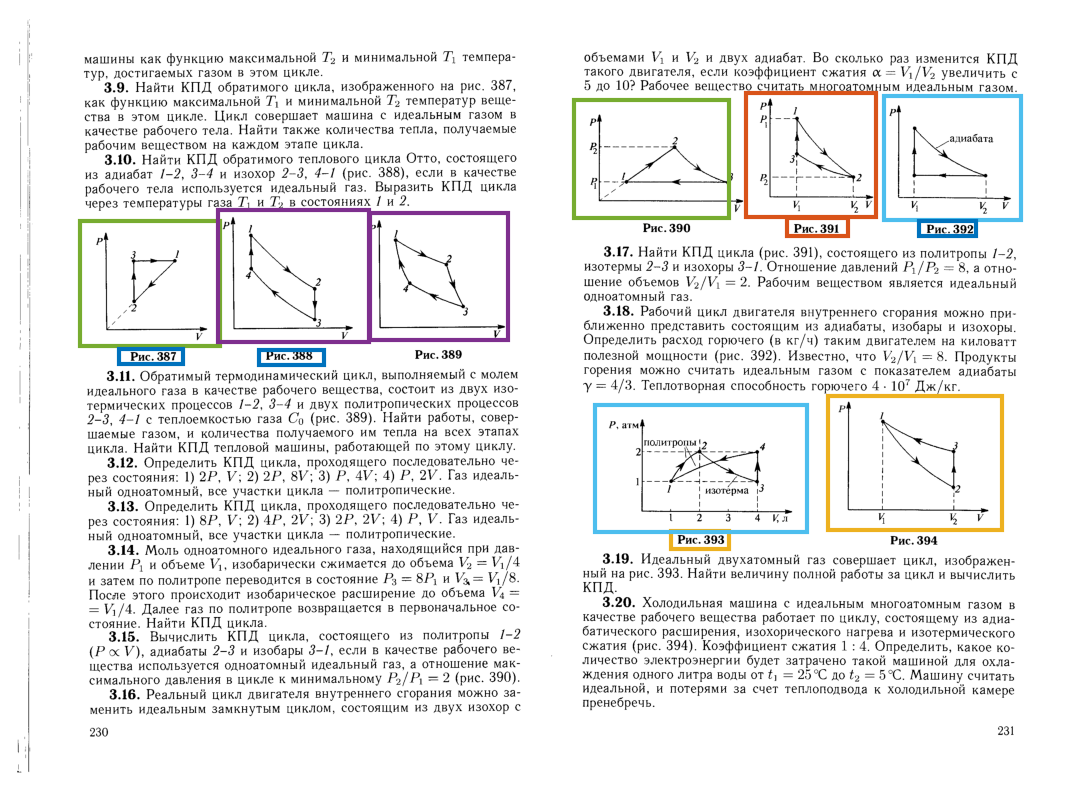

In [ ]:
from PIL import Image
image_id = target['image_id'].item()
image = val_dataset.coco.loadImgs(image_id)[0]
image = Image.open(image['file_name'])

visualize_predictions(image, outputs)

In [ ]:
from google.colab import userdata
token = userdata.get('HuggingFaceToken')

In [ ]:
model.model.push_to_hub('NMashalov/PhysicsYoLO',token=token)

model.safetensors:   0%|          | 0.00/123M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/NMashalov/PhysicsYoLO/commit/471d84fc95e1e7a823db4d64bebdd6026903db9c', commit_message='Upload YolosForObjectDetection', commit_description='', oid='471d84fc95e1e7a823db4d64bebdd6026903db9c', pr_url=None, pr_revision=None, pr_num=None)

## Пробуем на электричестве

In [ ]:
!gdown 1TaYNh2Oo41C4DDky5DwdRSGrfS9s_-En

Downloading...
From: https://drive.google.com/uc?id=1TaYNh2Oo41C4DDky5DwdRSGrfS9s_-En
To: /content/Kozel-SM-Sbornik-zadach-po-obschemu-kursu-fiziki-Chast-2-Elektrichestvo-i-magnetizm-Optika.pdf
100% 16.4M/16.4M [00:00<00:00, 70.6MB/s]


In [ ]:
!apt install ghostscript > /dev/null

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre ghostscript-x poppler-utils
  fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript libgs9 libgs9-common libidn12
  libijs-0.35 libjbig2dec0 poppler-data
0 upgraded, 10 newly installed, 0 to remove and 32 not upgraded.
Need to get 16.7 MB of archives.
After this operation, 63.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-droid-fallback all 1:6.0.1r16-1.1build1 [1,805 kB]
Ge

In [ ]:
!mkdir optika_png

In [ ]:
!gs -dNOPAUSE -dBATCH -sDEVICE=png16m -r300 -sOutputFile="optika_png/Pic%d.png" Optika.pdf

GPL Ghostscript 9.55.0 (2021-09-27)
Copyright (C) 2021 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the file COPYING for details.
Processing pages 1 through 366.
Page 1
Page 2
Page 3
Page 4
Page 5
Page 6
Page 7
Page 8
Page 9
Page 10
Page 11
Page 12
Page 13
Page 14
Page 15
Page 16
Page 17
Page 18
Page 19
Page 20
Page 21
Page 22
Page 23
Page 24
Page 25
Page 26
Page 27
Page 28
Page 29
Page 30
Page 31
Page 32
Page 33
Page 34
Page 35
Page 36
Page 37
Page 38
Page 39
Page 40
Page 41
Page 42
Page 43
Page 44
Page 45
Page 46
Page 47
Page 48
Page 49
Page 50
Page 51
Page 52
Page 53
Page 54
Page 55
Page 56
Page 57
Page 58
Page 59
Page 60
Page 61
Page 62
Page 63
Page 64
Page 65
Page 66
Page 67
Page 68
Page 69
Page 70
Page 71
Page 72
Page 73
Page 74
Page 75
Page 76
Page 77
Page 78
Page 79
Page 80
Page 81
Page 82
Page 83
Page 84
Page 85
Page 86
Page 87
Page 88
Page 89
Page 90
Page 91
Page 92
Page 93
Page 94
Page 95
Page 96


In [ ]:
img = Image.open('optika_png/Pic105.png')

In [ ]:
pixel_outputs = feature_extractor(images=img, return_tensors="pt")['pixel_values']

In [ ]:
outputs = model(pixel_outputs.to('cuda'))

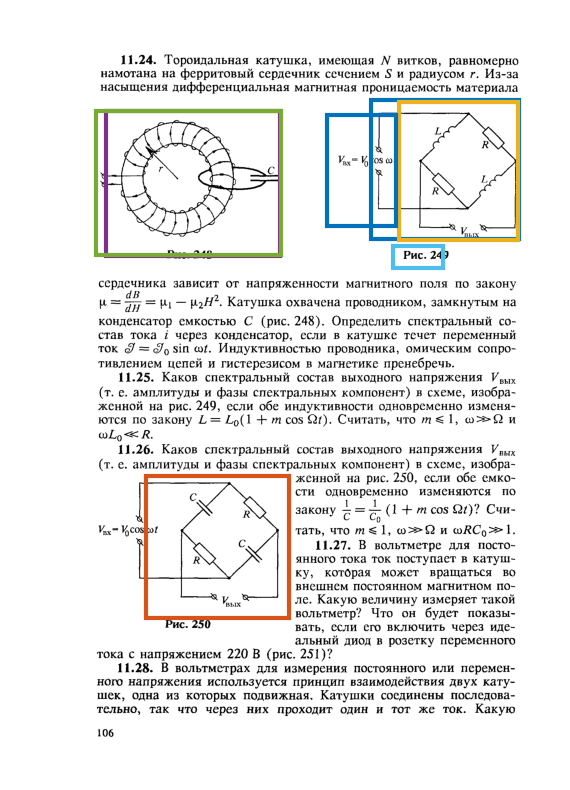

In [ ]:
visualize_predictions(img, outputs)

In [ ]:
'pixel_values'

{'pixel_values': tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400

In [ ]:
coco.annToMask(anns[0])

IndexError: list index out of range

In [ ]:
mask = coco.annToMask(anns[1])
for i in range(len(anns)):
    mask += coco.annToMask(anns[i])

IndexError: list index out of range

In [ ]:
image = np.array(Image.open(os.path.join(img_dir, img['file_name'])))
plt.imshow(image, interpolation='nearest')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/label-studio/files/ocr/Pic166.png'